**Problem Statement:**<br>
Design, implement, and train a machine learning model to automatically categorize resumes based on their domain (e.g., sales, marketing, etc.).

Dataset:
This [dataset](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset) was suggested for the task.


### Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
data_path= "/kaggle/input/resume-dataset/Resume/Resume.csv"
data_df= pd.read_csv(data_path)
data_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


#### Exploratory Data Analysis (EDA)

**Data description:**<br>
The dataset is arranged in a `.csv` file. This dataset contains 4 columns. They are described as, <br>
* ID: Unique identifier and file name for the respective resume.
* Resume_str : Contains the resume text only in string format.
* Resume_html : Contains the resume data in html format as present while web scrapping.
* Category : Category of resume.


There are `2484` resumes in total in the dataset. The dataset is small in size. `Training bigger model will be an issue as they needs bigger dataset and tends to overfit.`

In [3]:
display(data_df.columns)

print(f"Total no of resumes in the dataset: {len(data_df)}")

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')

Total no of resumes in the dataset: 2484


For our task we don't need `Resume_html` column. So, we will drop it. Then we will explore the dataset.

In [4]:
data_df.drop(columns= ["Resume_html"], axis= 1, inplace= True)
data_df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


First we will check the dataset info, dataset statistics and whether there is any missing data the dataset.

In [5]:
data_df.info ## didn't help

<bound method DataFrame.info of             ID                                         Resume_str  Category
0     16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...        HR
1     22323967           HR SPECIALIST, US HR OPERATIONS      ...        HR
2     33176873           HR DIRECTOR       Summary      Over 2...        HR
3     27018550           HR SPECIALIST       Summary    Dedica...        HR
4     17812897           HR MANAGER         Skill Highlights  ...        HR
...        ...                                                ...       ...
2479  99416532           RANK: SGT/E-5 NON- COMMISSIONED OFFIC...  AVIATION
2480  24589765           GOVERNMENT RELATIONS, COMMUNICATIONS ...  AVIATION
2481  31605080           GEEK SQUAD AGENT         Professional...  AVIATION
2482  21190805           PROGRAM DIRECTOR / OFFICE MANAGER    ...  AVIATION
2483  37473139           STOREKEEPER II       Professional Sum...  AVIATION

[2484 rows x 3 columns]>

In [6]:
display(data_df.isnull().sum())

ID            0
Resume_str    0
Category      0
dtype: int64

There is no missing value which is good.<br>

Lets explore the categories and their distribution

In [7]:
categories= sorted(data_df['Category'].unique())
print(f"Total no of categories are: {len(categories)}")

display(categories)

Total no of categories are: 24


['ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER']

In [8]:
data_df['Category'].value_counts().sort_index()

ACCOUNTANT                118
ADVOCATE                  118
AGRICULTURE                63
APPAREL                    97
ARTS                      103
AUTOMOBILE                 36
AVIATION                  117
BANKING                   115
BPO                        22
BUSINESS-DEVELOPMENT      120
CHEF                      118
CONSTRUCTION              112
CONSULTANT                115
DESIGNER                  107
DIGITAL-MEDIA              96
ENGINEERING               118
FINANCE                   118
FITNESS                   117
HEALTHCARE                115
HR                        110
INFORMATION-TECHNOLOGY    120
PUBLIC-RELATIONS          111
SALES                     116
TEACHER                   102
Name: Category, dtype: int64

[Text(0, 0, '120'),
 Text(0, 0, '120'),
 Text(0, 0, '118'),
 Text(0, 0, '118'),
 Text(0, 0, '118'),
 Text(0, 0, '118'),
 Text(0, 0, '118'),
 Text(0, 0, '117'),
 Text(0, 0, '117'),
 Text(0, 0, '116'),
 Text(0, 0, '115'),
 Text(0, 0, '115'),
 Text(0, 0, '115'),
 Text(0, 0, '112'),
 Text(0, 0, '111'),
 Text(0, 0, '110'),
 Text(0, 0, '107'),
 Text(0, 0, '103'),
 Text(0, 0, '102'),
 Text(0, 0, '97'),
 Text(0, 0, '96'),
 Text(0, 0, '63'),
 Text(0, 0, '36'),
 Text(0, 0, '22')]

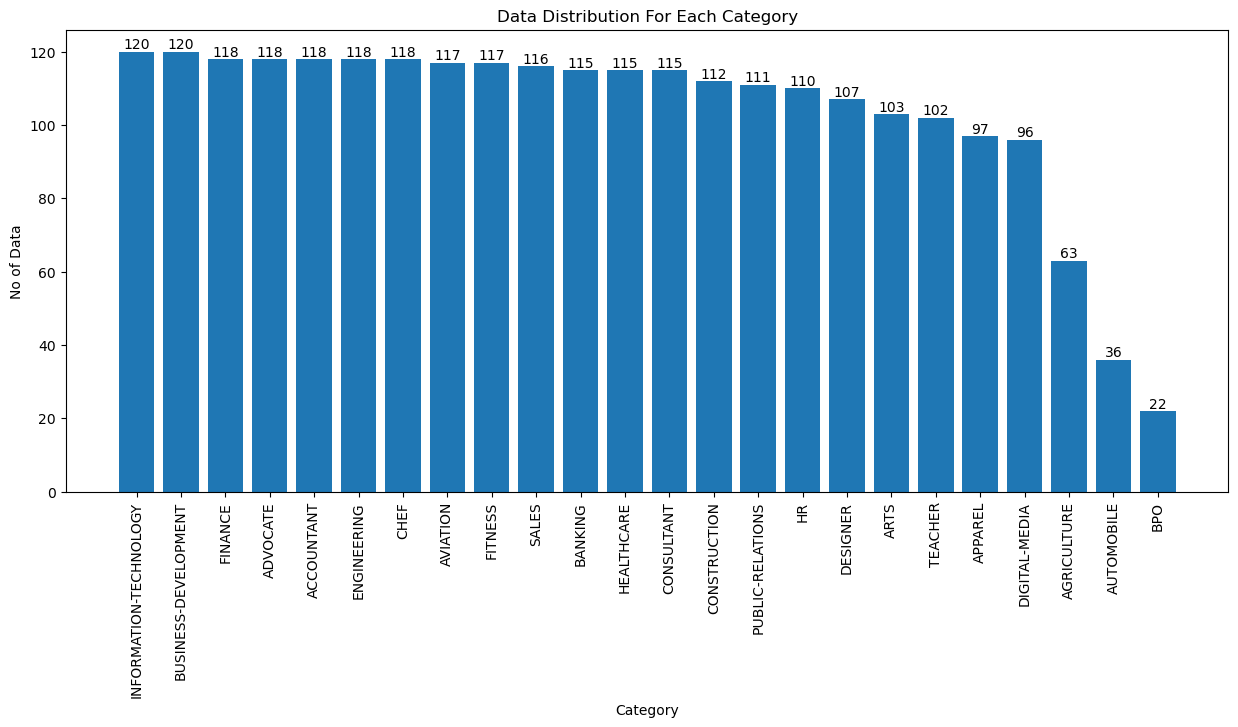

In [9]:
fig, ax = plt.subplots(figsize= (15, 6))
bars = ax.bar(data_df['Category'].value_counts().index, 
              height= data_df['Category'].value_counts().values)

plt.xticks(rotation= 'vertical')
plt.title("Data Distribution For Each Category")
plt.xlabel("Category")
plt.ylabel("No of Data")
ax.bar_label(bars)

From the above bar-plot we can see that most of the categories have around 100+ resumes but some of the categories have a few data. So dataset is slightly imblance. So we have to be carefull during training so that the model miss these categories. Moreover we also chose model metrics carefully. We can't only use classification accuracy as model metrics as dataset is `imbalance`. We will use `F1_Score` for our model evaluation.

#### Some More EDA and Preprocessing

Lets explore contents in resumes.

In [10]:
print(f"No of rows in the dataset: {len(data_df)}")
print(f"No of unique resumes: {len(data_df['Resume_str'].unique())}")

No of rows in the dataset: 2484
No of unique resumes: 2482


So there are `some duplicate` resumes in the dataset.

In [11]:
data_df['resume_length']= data_df['Resume_str'].apply(lambda x: len(x))
data_df.head()

,ID,Resume_str,Category,resume_length
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,5442
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,5572
2,33176873,HR DIRECTOR Summary Over 2...,HR,7720
3,27018550,HR SPECIALIST Summary Dedica...,HR,2855
4,17812897,HR MANAGER Skill Highlights ...,HR,9172


In [12]:
display(len(data_df['resume_length'].unique()))
data_df['resume_length'].value_counts()[:10]

2033

5250    5
5196    5
5980    4
5403    4
5533    4
5515    4
6664    4
5130    4
5776    4
5295    4
Name: resume_length, dtype: int64

Text(0.5, 1.0, 'Resume Length Distribution')

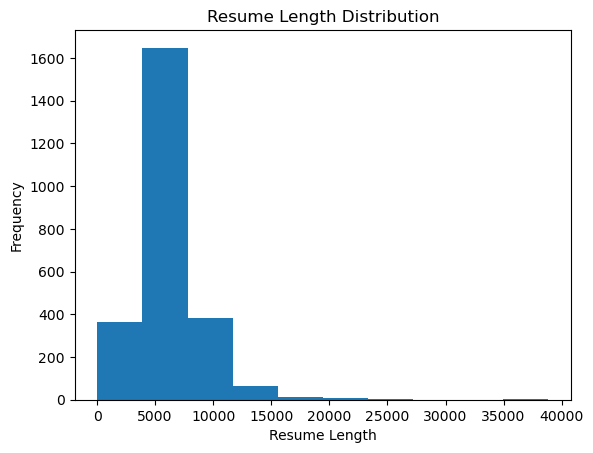

In [13]:
plt.hist(data_df['resume_length'].values)
plt.xlabel("Resume Length")
plt.ylabel("Frequency")
plt.title("Resume Length Distribution")

In [14]:
print(f"Maximum length of resumes: {max(data_df.resume_length)}")
print(f"Minimum length of resumes: {min(data_df.resume_length)}")

data_df['resume_length'].describe()

Maximum length of resumes: 38842
Minimum length of resumes: 21


count     2484.000000
mean      6295.308776
std       2769.251458
min         21.000000
25%       5160.000000
50%       5886.500000
75%       7227.250000
max      38842.000000
Name: resume_length, dtype: float64

In [15]:
data_df['no_words']= data_df['Resume_str'].apply(lambda x: len(x.split()))
data_df.no_words.describe()

count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: no_words, dtype: float64

Text(0.5, 1.0, 'Word count Distribution')

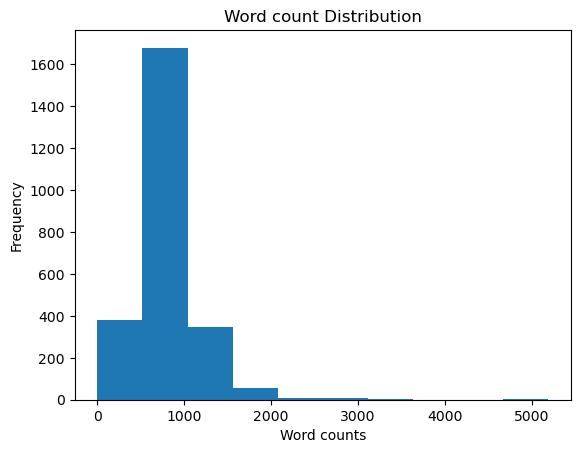

In [16]:
plt.hist(data_df['no_words'].values)
plt.xlabel("Word counts")
plt.ylabel("Frequency")
plt.title("Word count Distribution")

Most of the resume are different in size and `90%` data have `length < 8000` and `word count is < 1000`.

Lets investigate the vocabulary of the resumes.

In [17]:
def word_vocab(data):
    vocabulary= {}
    for resume in tqdm(data.values):
        for word in resume.split():
            try:
                vocabulary[word] += 1
            except:
                vocabulary[word] = 1
    sorted_vocab= sorted(vocabulary.items(), key= lambda kv:kv[1], reverse= True)
    return vocabulary, sorted_vocab

vocabulary, sorted_vocab= word_vocab(data_df['Resume_str'])

100%|██████████| 2484/2484 [00:00<00:00, 3936.75it/s]


In [18]:
sorted_vocab= sorted(vocabulary.items(), key= lambda kv:kv[1], reverse= True)

print(f"Total unique words in the vocabulary: {len(sorted_vocab)}")

sorted_vocab[:20]


Total unique words in the vocabulary: 111423


[('and', 122399),
 ('to', 53429),
 ('of', 42633),
 ('the', 35494),
 ('for', 28105),
 ('in', 27020),
 ('with', 21462),
 (',', 18910),
 ('a', 15613),
 ('State', 15278),
 ('City', 14889),
 ('Company', 11810),
 ('Name', 11602),
 ('on', 9968),
 ('as', 9950),
 ('all', 8452),
 ('－', 6890),
 ('by', 6687),
 ('customer', 5796),
 ('-', 5599)]

So, `111423` unique words in the vocabulary which is `huge` for a smaller dataset.<br>

Lets `remove stopwords` from the resumes as they are very common and see the effect in word vocabulary.

In [19]:
important_punctuations= [p for p in "()-.:;?/_{|}"]
important_punctuations

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as word_tokenizer

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
print(f"Total stop words: {len(stop_words)}")
# stop_words

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Total stop words: 179


In [20]:
def remove_stop_words(txt):
    words = word_tokenizer(txt)
    imp_words = [word for word in words if word not in stop_words and word not in important_punctuations]
    text = ' '.join(imp_words)
    return text

###
data_df['Modified_Resume_str']= data_df['Resume_str'].apply(remove_stop_words)

Now lets check what happens to our word vocabulary and resume lengths

In [21]:
modified_vocab, sorted_modified_vocab = word_vocab(data_df['Modified_Resume_str'])

print(f"Total unique words in the vocabulary: {len(sorted_modified_vocab)}")

sorted_modified_vocab[:20]

100%|██████████| 2484/2484 [00:00<00:00, 5118.69it/s]


Total unique words in the vocabulary: 73200


[(',', 186142),
 ('State', 15335),
 ('City', 14950),
 ('Company', 11924),
 ('Name', 11653),
 ('management', 6925),
 ('－', 6890),
 ('customer', 6042),
 ('sales', 5553),
 ('&', 5524),
 ('new', 5459),
 ("'s", 5211),
 ('Management', 4991),
 ('team', 4599),
 ('I', 4476),
 ('business', 4376),
 ('service', 4258),
 ('skills', 4161),
 ('including', 3997),
 ('development', 3795)]

> Vocabulary size reduced to `73200` from `111423` which is a huge reduction in size.

Text(0.5, 1.0, 'Resume Length Distribution [after removing stop words]')

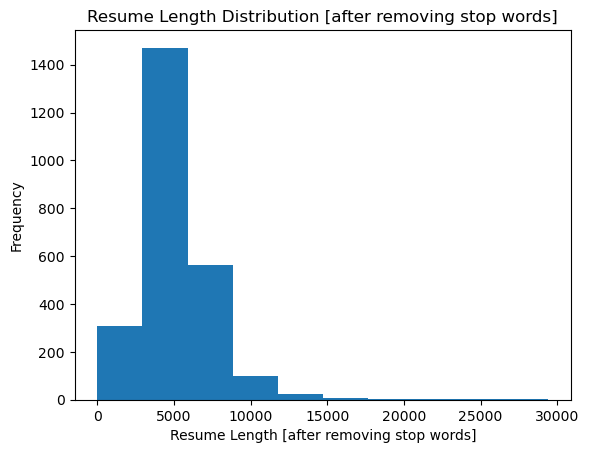

In [22]:
data_df['modified_resume_length']= data_df['Modified_Resume_str'].apply(lambda x: len(x))

plt.hist(data_df['modified_resume_length'].values)
plt.xlabel("Resume Length [after removing stop words]")
plt.ylabel("Frequency")
plt.title("Resume Length Distribution [after removing stop words]")

count    2484.000000
mean      699.194847
std       319.149530
min         0.000000
25%       560.000000
50%       653.500000
75%       810.500000
max      4052.000000
Name: modified_no_words, dtype: float64

Text(0.5, 1.0, 'Word count Distribution [after removing stop words]')

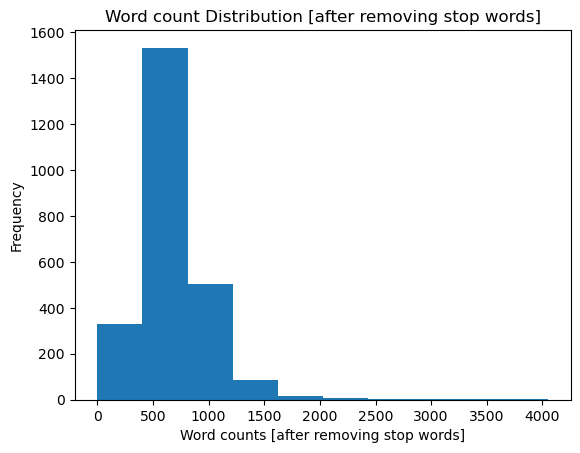

In [23]:
data_df['modified_no_words']= data_df['Modified_Resume_str'].apply(lambda x: len(x.split()))
display(data_df.modified_no_words.describe())

plt.hist(data_df['modified_no_words'].values)
plt.xlabel("Word counts [after removing stop words]")
plt.ylabel("Frequency")
plt.title("Word count Distribution [after removing stop words]")

Lets chcek `character occurance distribution`.

In [24]:
def char_vocab(data_df):
    chars = {}
    for resume in tqdm(data_df.Resume_str):
        for char in resume:
            try:
                chars[char] += 1
            except:
                chars[char] = 1
    return chars

chars= char_vocab(data_df)

print(f"Total Unique Characters: {len(chars)}")
display(chars)

100%|██████████| 2484/2484 [00:01<00:00, 1307.54it/s]

Total Unique Characters: 162


{' ': 2897374,
 'H': 19278,
 'R': 36235,
 'A': 69757,
 'D': 33478,
 'M': 52113,
 'I': 40931,
 'N': 32806,
 'S': 92016,
 'T': 35560,
 'O': 26609,
 '/': 25090,
 'K': 4513,
 'E': 45923,
 'G': 14036,
 'C': 94612,
 '\n': 16580,
 'u': 307338,
 'm': 322731,
 'a': 969129,
 'r': 771183,
 'y': 170076,
 'e': 1361129,
 'd': 477194,
 'i': 947913,
 'c': 473750,
 't': 960319,
 's': 764539,
 'o': 821521,
 'v': 140309,
 'n': 996602,
 'g': 267846,
 'w': 97091,
 'h': 222609,
 '1': 38322,
 '5': 11040,
 '+': 1400,
 'f': 206237,
 'x': 32749,
 'p': 312523,
 'l': 478546,
 '.': 98373,
 'b': 98050,
 '-': 31156,
 ';': 4771,
 ',': 187440,
 'F': 19195,
 'k': 67457,
 'q': 17039,
 'L': 21138,
 'W': 13935,
 'Q': 4022,
 'P': 54884,
 '(': 9270,
 ')': 9414,
 '2': 40491,
 '0': 70307,
 '3': 9959,
 '－': 6890,
 '\xa0': 8877,
 "'": 7130,
 'z': 14259,
 '9': 12925,
 'J': 7636,
 'j': 13640,
 '7': 6531,
 '&': 5524,
 '4': 8974,
 'B': 21032,
 '8': 7160,
 'U': 13624,
 'V': 8659,
 '%': 2534,
 '·': 617,
 ':': 10933,
 'Y': 2907,
 '"':

In [25]:
chars.keys()

dict_keys([' ', 'H', 'R', 'A', 'D', 'M', 'I', 'N', 'S', 'T', 'O', '/', 'K', 'E', 'G', 'C', '\n', 'u', 'm', 'a', 'r', 'y', 'e', 'd', 'i', 'c', 't', 's', 'o', 'v', 'n', 'g', 'w', 'h', '1', '5', '+', 'f', 'x', 'p', 'l', '.', 'b', '-', ';', ',', 'F', 'k', 'q', 'L', 'W', 'Q', 'P', '(', ')', '2', '0', '3', '－', '\xa0', "'", 'z', '9', 'J', 'j', '7', '&', '4', 'B', '8', 'U', 'V', '%', '·', ':', 'Y', '"', '6', '*', '\t', 'Z', 'X', '–', '[', ']', '~', '?', '\u200b', '_', '•', '“', '”', '‘', '�', '$', '|', '#', '\uf0b7', 'é', '\xad', '●', '!', '—', '½', '➢', '}', '@', '³', '\\', '>', '◦', '®', 'á', 'í', 'ú', 'ó', 'ö', '=', 'ñ', '{', 'â', '€', '¢', '™', 'Á', '‚', 'è', '´', '\uf046', '❖', '<', 'À', '▪', 'ﬁ', 'Â', 'Ç', 'ü', '’', '❏', '\u2028', '§', 'ô', '…', 'Ò', 'Ó', 'É', '»', 'ï', '©', 'Æ', '−', '¦', '◆', 'Ñ', '𝐖', '\x92', 'ç', '\uf0a7', 'µ', 'ê', '─', '‐'])

In [26]:
sorted_chars= sorted(chars.items(), key= lambda kv: kv[1], reverse= True)
display(sorted_chars[:10])

[(' ', 2897374),
 ('e', 1361129),
 ('n', 996602),
 ('a', 969129),
 ('t', 960319),
 ('i', 947913),
 ('o', 821521),
 ('r', 771183),
 ('s', 764539),
 ('l', 478546)]

In [27]:
dict(sorted_chars).keys()

dict_keys([' ', 'e', 'n', 'a', 't', 'i', 'o', 'r', 's', 'l', 'd', 'c', 'm', 'p', 'u', 'g', 'h', 'f', ',', 'y', 'v', '.', 'b', 'w', 'C', 'S', '0', 'A', 'k', 'P', 'M', 'E', 'I', '2', '1', 'R', 'T', 'D', 'N', 'x', '-', 'O', '/', 'L', 'B', 'H', 'F', 'q', '\n', 'z', 'G', 'W', 'j', 'U', '9', '5', ':', '3', ')', '(', '4', '\xa0', 'V', 'J', '6', '\t', '8', "'", '－', '7', '&', ';', 'K', 'Q', 'Y', '%', '"', '$', '*', 'X', '–', '+', '•', '_', ']', '[', '·', 'Z', '|', '\u200b', '#', '=', '?', '\xad', '●', '!', '“', '”', 'é', '➢', '~', 'ó', '◦', '>', '@', '\\', 'í', '®', '❖', '…', '�', 'á', '−', '§', 'â', '\uf0a7', '‘', '◆', 'ñ', '—', '€', 'è', '<', '™', 'ú', '’', '❏', '\u2028', '‚', '½', '}', '´', '¦', 'ô', 'Ó', '‐', '▪', 'É', '©', 'ö', '{', '\uf046', 'ü', 'Â', 'Æ', 'Ñ', '\x92', 'µ', '\uf0b7', '³', '¢', 'Á', 'À', 'ﬁ', 'Ç', 'Ò', '»', 'ï', '𝐖', 'ç', 'ê', '─'])

Total `162` characters thats huge for english vocabulary. There are some `Non-english` chacters which we will not need for our task. There are also uper-case lower-case issue. So, we will convert all the letters to lower case.

In [28]:
def remove_unwanted_chars(txt):
    """This function will make all the input text in lower case to reduce the char vocab size and delete all the unwanted characters and punctuations.
    """
    txt= txt.lower()
    pattern = r"[^a-z\s\d()-.:;?\/^_{|}]" # Discarding all the un-necessary letters keeping english letters and necessary punctuations
    txt= re.sub(pattern, ' ', txt)
    txt= ' '.join(txt.split())
    return txt

data_df['Resume_str']= data_df['Resume_str'].apply(lambda x: remove_unwanted_chars(x))
data_df.head()

,ID,Resume_str,Category,resume_length,no_words,Modified_Resume_str,modified_resume_length,modified_no_words
0,16852973,hr administrator/marketing associate hr admini...,HR,5442,674,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...,4577,617
1,22323967,"hr specialist, us hr operations summary versat...",HR,5572,708,"HR SPECIALIST , US HR OPERATIONS Summary Versa...",4678,621
2,33176873,hr director summary over 20 years experience i...,HR,7720,1017,HR DIRECTOR Summary Over 20 years experience r...,6368,846
3,27018550,"hr specialist summary dedicated, driven, and d...",HR,2855,379,"HR SPECIALIST Summary Dedicated , Driven , Dyn...",2287,304
4,17812897,hr manager skill highlights hr skills hr depar...,HR,9172,1206,HR MANAGER Skill Highlights HR SKILLS HR Depar...,7861,1076


In [29]:
chars= char_vocab(data_df)

print(f"Total Unique Characters after lower-casing and removing non-english characters: {len(chars)}")
display(chars)

100%|██████████| 2484/2484 [00:01<00:00, 1313.59it/s]

Total Unique Characters after lower-casing and removing non-english characters: 52


{'h': 241887,
 'r': 807418,
 ' ': 2005234,
 'a': 1038886,
 'd': 510672,
 'm': 374844,
 'i': 988844,
 'n': 1029408,
 's': 856555,
 't': 995879,
 'o': 848130,
 '/': 25090,
 'k': 71970,
 'e': 1407052,
 'g': 281882,
 'c': 568362,
 'u': 320962,
 'y': 172983,
 'v': 148968,
 'w': 111026,
 '1': 38322,
 '5': 11040,
 '+': 1400,
 'f': 225432,
 'x': 34571,
 'p': 367407,
 'l': 499684,
 '.': 98373,
 'b': 119082,
 '-': 31156,
 ';': 4771,
 ',': 187440,
 'q': 21061,
 '(': 9270,
 ')': 9414,
 '2': 40491,
 '0': 70307,
 '3': 9959,
 'z': 14747,
 '9': 12925,
 'j': 21276,
 '7': 6531,
 '4': 8974,
 '8': 7160,
 ':': 10933,
 '6': 7417,
 '*': 1974,
 '?': 157,
 '_': 866,
 '|': 411,
 '}': 6,
 '{': 3}

In [30]:
sorted_chars= sorted(chars.items(), key= lambda kv: kv[1], reverse= True)
display(sorted_chars[:10])

[(' ', 2005234),
 ('e', 1407052),
 ('a', 1038886),
 ('n', 1029408),
 ('t', 995879),
 ('i', 988844),
 ('s', 856555),
 ('o', 848130),
 ('r', 807418),
 ('c', 568362)]

> No of unique character reduced to `52` from `162` which is reasonable as we didn't discarded some important punctuations. <br>

Lets see the character occurance distribution in bar diagram for better visualization.

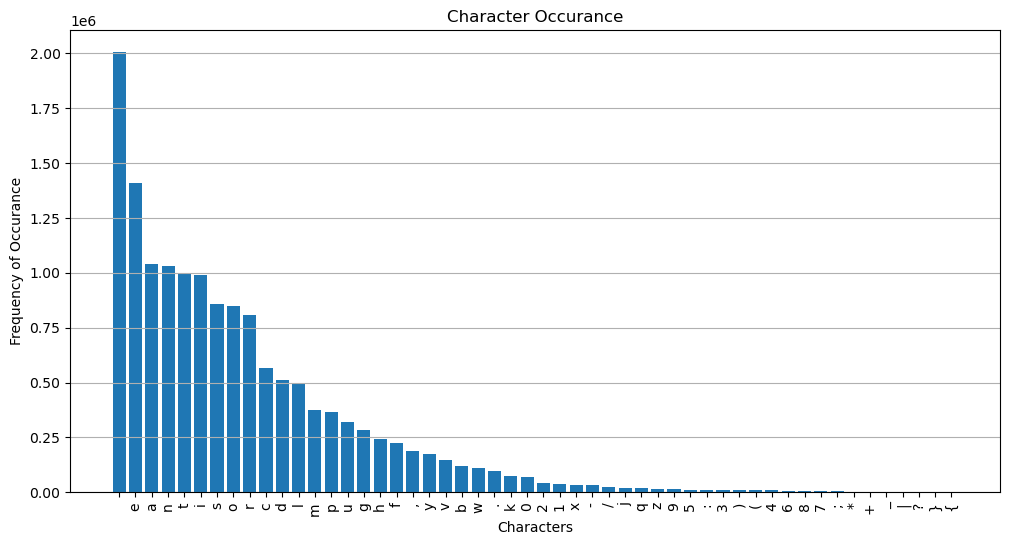

In [31]:
sorted_chars= dict(sorted_chars)
plt.figure(figsize= (12, 6))
plt.bar(x= sorted_chars.keys(), height= sorted_chars.values())
plt.title("Character Occurance")
plt.xlabel("Characters")
plt.ylabel("Frequency of Occurance")
plt.xticks(rotation= 'vertical')
plt.grid(axis= 'y')
plt.show()

### Modeling

**Random classifier**

Lets say we assign a random class (same) to all the resumes. Then the heightest accuracy that it can get is `4.83%` which was expected as we have 24 classes in our lebel class.

In [32]:
print(f"Accuracy (heighest) of random classifier: {max(data_df['Category'].value_counts().values)/len(data_df)* 100  :.2f}%")

Accuracy (heighest) of random classifier: 4.83%


**A naive approach** <br>
If someone apply for a certain post, his/her resume will contain more of this position related word. So we will count the occurance of each category words and classify the resume according to the frequency of category occurance.

In [33]:
categories

['ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER']

In [34]:
lower_cat= sorted([cat.lower() for cat in categories])
lower_cat

['accountant',
 'advocate',
 'agriculture',
 'apparel',
 'arts',
 'automobile',
 'aviation',
 'banking',
 'bpo',
 'business-development',
 'chef',
 'construction',
 'consultant',
 'designer',
 'digital-media',
 'engineering',
 'finance',
 'fitness',
 'healthcare',
 'hr',
 'information-technology',
 'public-relations',
 'sales',
 'teacher']

In [35]:
def naive_approach(txt):
    """In this approach we will count the occurance of each category words and classify according highest occuring category.
    """
    temp_dict= {}
    for word in txt.split():
        if word in lower_cat:
            try:
                temp_dict[word] += 1
            except:
                temp_dict[word] = 1

    temp_dict= sorted(temp_dict.items(), key= lambda kv: kv[1], reverse= True)
    
    if len(temp_dict):
        label= (temp_dict[0][0])
        label= label.upper()
    else:
        label= None
    return label

In [36]:
idx= 180
display(data_df.iloc[idx])
naive_approach(data_df['Resume_str'][idx])

ID                                                                 20748926
Resume_str                jewelry designer and owner summary skillful an...
Category                                                           DESIGNER
resume_length                                                          6312
no_words                                                                782
Modified_Resume_str       JEWELRY DESIGNER AND OWNER Summary Skillful de...
modified_resume_length                                                 5312
modified_no_words                                                       683
Name: 180, dtype: object

'DESIGNER'

In [37]:
data_df['naive_predict']= data_df.apply(lambda x: naive_approach(x["Resume_str"]), axis = 1)
data_df.head()

,ID,Resume_str,Category,resume_length,no_words,Modified_Resume_str,modified_resume_length,modified_no_words,naive_predict
0,16852973,hr administrator/marketing associate hr admini...,HR,5442,674,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...,4577,617,HR
1,22323967,"hr specialist, us hr operations summary versat...",HR,5572,708,"HR SPECIALIST , US HR OPERATIONS Summary Versa...",4678,621,HR
2,33176873,hr director summary over 20 years experience i...,HR,7720,1017,HR DIRECTOR Summary Over 20 years experience r...,6368,846,HR
3,27018550,"hr specialist summary dedicated, driven, and d...",HR,2855,379,"HR SPECIALIST Summary Dedicated , Driven , Dyn...",2287,304,HR
4,17812897,hr manager skill highlights hr skills hr depar...,HR,9172,1206,HR MANAGER Skill Highlights HR SKILLS HR Depar...,7861,1076,HR


In [38]:
predictions= [1 if label == pred else 0 for label, pred in zip(data_df['Category'], data_df['naive_predict'])]
print(f"Accuracy of that naive approach: {sum(predictions)/len(data_df) * 100}")

Accuracy of that naive approach: 55.31400966183575


> This approach result is much better (Accuracy `53.09%` without stopwords and `55.31%` with stopwords) than a random classifier.

In [39]:
len(categories)

24

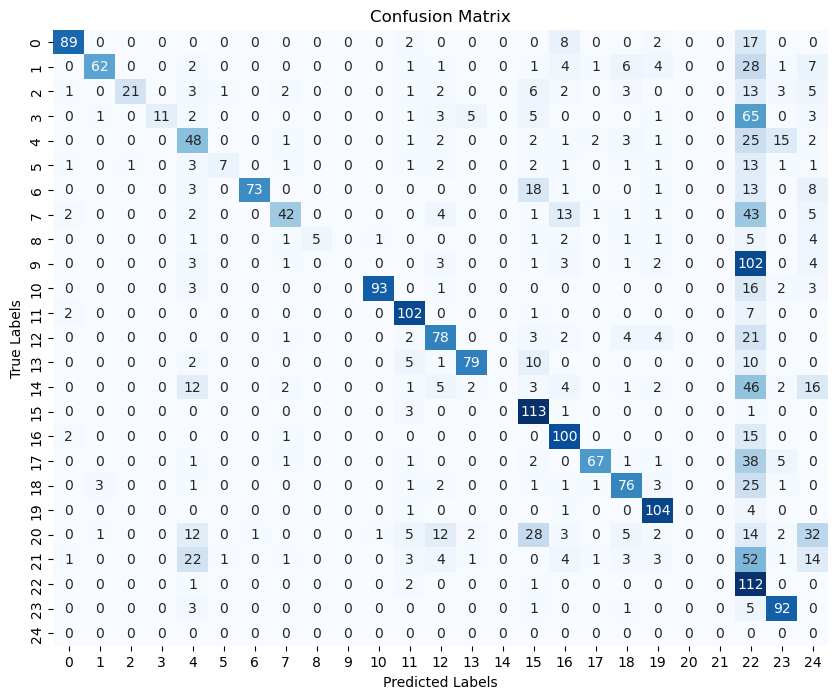

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels= [categories.index(label) for label in data_df['Category']]
predicted_labels= [categories.index(label) if label!=None else 24 for label in data_df['naive_predict'] ]
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

simple error analysis for this naive process.

In [41]:
error_idx= [5, 8, 9, 14, 20, 21]
for i in error_idx:
    print(i, categories[i])

5 AUTOMOBILE
8 BPO
9 BUSINESS-DEVELOPMENT
14 DIGITAL-MEDIA
20 INFORMATION-TECHNOLOGY
21 PUBLIC-RELATIONS


In [42]:
label2id= {}
id2label= {}
for i, cat in enumerate(categories):
    label2id[cat] = i
    id2label[str(i)]= cat

display(label2id)
display(id2label)

{'ACCOUNTANT': 0,
 'ADVOCATE': 1,
 'AGRICULTURE': 2,
 'APPAREL': 3,
 'ARTS': 4,
 'AUTOMOBILE': 5,
 'AVIATION': 6,
 'BANKING': 7,
 'BPO': 8,
 'BUSINESS-DEVELOPMENT': 9,
 'CHEF': 10,
 'CONSTRUCTION': 11,
 'CONSULTANT': 12,
 'DESIGNER': 13,
 'DIGITAL-MEDIA': 14,
 'ENGINEERING': 15,
 'FINANCE': 16,
 'FITNESS': 17,
 'HEALTHCARE': 18,
 'HR': 19,
 'INFORMATION-TECHNOLOGY': 20,
 'PUBLIC-RELATIONS': 21,
 'SALES': 22,
 'TEACHER': 23}

{'0': 'ACCOUNTANT',
 '1': 'ADVOCATE',
 '2': 'AGRICULTURE',
 '3': 'APPAREL',
 '4': 'ARTS',
 '5': 'AUTOMOBILE',
 '6': 'AVIATION',
 '7': 'BANKING',
 '8': 'BPO',
 '9': 'BUSINESS-DEVELOPMENT',
 '10': 'CHEF',
 '11': 'CONSTRUCTION',
 '12': 'CONSULTANT',
 '13': 'DESIGNER',
 '14': 'DIGITAL-MEDIA',
 '15': 'ENGINEERING',
 '16': 'FINANCE',
 '17': 'FITNESS',
 '18': 'HEALTHCARE',
 '19': 'HR',
 '20': 'INFORMATION-TECHNOLOGY',
 '21': 'PUBLIC-RELATIONS',
 '22': 'SALES',
 '23': 'TEACHER'}

In [43]:
data_df['labels']= data_df['Category'].apply(lambda x: int(label2id[x]))
data_df.head()

,ID,Resume_str,Category,resume_length,no_words,Modified_Resume_str,modified_resume_length,modified_no_words,naive_predict,labels
0,16852973,hr administrator/marketing associate hr admini...,HR,5442,674,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...,4577,617,HR,19
1,22323967,"hr specialist, us hr operations summary versat...",HR,5572,708,"HR SPECIALIST , US HR OPERATIONS Summary Versa...",4678,621,HR,19
2,33176873,hr director summary over 20 years experience i...,HR,7720,1017,HR DIRECTOR Summary Over 20 years experience r...,6368,846,HR,19
3,27018550,"hr specialist summary dedicated, driven, and d...",HR,2855,379,"HR SPECIALIST Summary Dedicated , Driven , Dyn...",2287,304,HR,19
4,17812897,hr manager skill highlights hr skills hr depar...,HR,9172,1206,HR MANAGER Skill Highlights HR SKILLS HR Depar...,7861,1076,HR,19


### Configurations

In [44]:
!pip install -q --upgrade wandb ## installing weight and bias

In [45]:
import time
import random
import torch
import json
import wandb
import gc
import string
from collections import defaultdict

from torch.optim import AdamW, lr_scheduler

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [46]:
class CONFIG:
    train= True #False #True
    test = True
    seed= 2023 #42
    n_fold= 3
    id2label= id2label
    label2id= label2id
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    num_labels= 24
    n_folds= 3
    num_epochs= 50
    
    output_dir= "./Models/"
    model_name_or_path= "microsoft/deberta-v3-large" #"xlnet-base-cased" #"microsoft/deberta-v3-base" # "microsoft/deberta-v3-small" #"bert-large-uncased" #"bert-base-uncased" # #"bert-base-uncased" # #"prajjwal1/bert-small"
    model_checkpoint= "./Models/Resume_classification_fold_0.bin" # This have to be changed with proper path
    token_max_length= 700 #1024 #512 # 1024 #bert-base-uncased must be run with 512 length
    train_batch_size= 2
    valid_batch_size= 2
    test_batch_size= 2
    num_workers= 2
    
    patience= 3
    gradient_accumulation_steps= 1
    learning_rate= 2e-5 #5e-5
    weight_decay= 1e-1
    scheduler= "CosineAnnealingWarmRestarts" #"linear"
    T_max= 500
    T_0= 500
    min_lr= 1e-8
    eps = 1e-6
    betas= [0.9, 0.999]
    
    wandb= False
    task= 'Resume_Classification'
    _wandb_kernel= 'Virus_Proton'
    
    
    

In [47]:
if CONFIG.wandb:
    import wandb

    from kaggle_secrets import UserSecretsClient
    user_secrets= UserSecretsClient()
    api_key= user_secrets.get_secret("wandb_api")
    wandb.login(key= api_key)

    ## creating random Hash name for every training to save in W&B

    def id_generator(size= 12, chars= string.ascii_lowercase+string.digits):
        return ''.join(random.SystemRandom().choice(chars) for _ in range(size))

    HASH_NAME= id_generator()
    print(HASH_NAME)
    
    CONFIG.hash_name= HASH_NAME
    CONFIG.group= f"Resume_classification-{HASH_NAME}_"

In [48]:
!pip install -q jsons

In [49]:
import jsons
#save the config 
with open('Configuration.json', 'w') as f:
    conf= CONFIG()
    conf= jsons.dump(conf)
    json.dump(conf, f)

display(conf)

{'T_0': 500,
 'T_max': 500,
 '_wandb_kernel': 'Virus_Proton',
 'betas': [0.9, 0.999],
 'device': {'index': 0, 'type': 'cuda'},
 'eps': 1e-06,
 'gradient_accumulation_steps': 1,
 'id2label': {'0': 'ACCOUNTANT',
  '1': 'ADVOCATE',
  '2': 'AGRICULTURE',
  '3': 'APPAREL',
  '4': 'ARTS',
  '5': 'AUTOMOBILE',
  '6': 'AVIATION',
  '7': 'BANKING',
  '8': 'BPO',
  '9': 'BUSINESS-DEVELOPMENT',
  '10': 'CHEF',
  '11': 'CONSTRUCTION',
  '12': 'CONSULTANT',
  '13': 'DESIGNER',
  '14': 'DIGITAL-MEDIA',
  '15': 'ENGINEERING',
  '16': 'FINANCE',
  '17': 'FITNESS',
  '18': 'HEALTHCARE',
  '19': 'HR',
  '20': 'INFORMATION-TECHNOLOGY',
  '21': 'PUBLIC-RELATIONS',
  '22': 'SALES',
  '23': 'TEACHER'},
 'label2id': {'ACCOUNTANT': 0,
  'ADVOCATE': 1,
  'AGRICULTURE': 2,
  'APPAREL': 3,
  'ARTS': 4,
  'AUTOMOBILE': 5,
  'AVIATION': 6,
  'BANKING': 7,
  'BPO': 8,
  'BUSINESS-DEVELOPMENT': 9,
  'CHEF': 10,
  'CONSTRUCTION': 11,
  'CONSULTANT': 12,
  'DESIGNER': 13,
  'DIGITAL-MEDIA': 14,
  'ENGINEERING': 15,
  

## CV split

As there are some imbalance in dataset, for robustness of our model we will use cross-validation method for training our model and evaluating our model performance.

>**We will make total 4 split and we will use first 3 splits for cross validation training and 1 spilt for final testing.**

In [50]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits= CONFIG.n_fold + 1, shuffle= True, random_state= CONFIG.seed)

for fold, (_, val_) in enumerate(skf.split(X= data_df, y= data_df['labels'])):
    data_df.loc[val_, "kfold"] = int(fold)

data_df['kfold']= data_df['kfold'].astype(int)

display(data_df.head(10))

display(data_df.groupby('kfold').size())

,ID,Resume_str,Category,resume_length,no_words,Modified_Resume_str,modified_resume_length,modified_no_words,naive_predict,labels,kfold
0,16852973,hr administrator/marketing associate hr admini...,HR,5442,674,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...,4577,617,HR,19,1
1,22323967,"hr specialist, us hr operations summary versat...",HR,5572,708,"HR SPECIALIST , US HR OPERATIONS Summary Versa...",4678,621,HR,19,2
2,33176873,hr director summary over 20 years experience i...,HR,7720,1017,HR DIRECTOR Summary Over 20 years experience r...,6368,846,HR,19,2
3,27018550,"hr specialist summary dedicated, driven, and d...",HR,2855,379,"HR SPECIALIST Summary Dedicated , Driven , Dyn...",2287,304,HR,19,0
4,17812897,hr manager skill highlights hr skills hr depar...,HR,9172,1206,HR MANAGER Skill Highlights HR SKILLS HR Depar...,7861,1076,HR,19,0
5,11592605,hr generalist summary dedicated and focused ad...,HR,5480,666,HR GENERALIST Summary Dedicated focused Admini...,4672,579,HR,19,2
6,25824789,hr manager summary human resources manager ext...,HR,5250,637,HR MANAGER Summary HUMAN RESOURCES MANAGER Ext...,4536,571,HR,19,0
7,15375009,hr manager professional summary senior hr prof...,HR,9033,1106,HR MANAGER Professional Summary Senior HR prof...,7730,951,HR,19,3
8,11847784,hr specialist summary possess 15+ years of exp...,HR,6720,796,HR SPECIALIST Summary Possess 15+ years experi...,5677,671,HR,19,3
9,32896934,hr clerk summary translates business vision in...,HR,5978,716,HR CLERK Summary Translates business vision HR...,5167,674,HR,19,2


kfold
0    621
1    621
2    621
3    621
dtype: int64

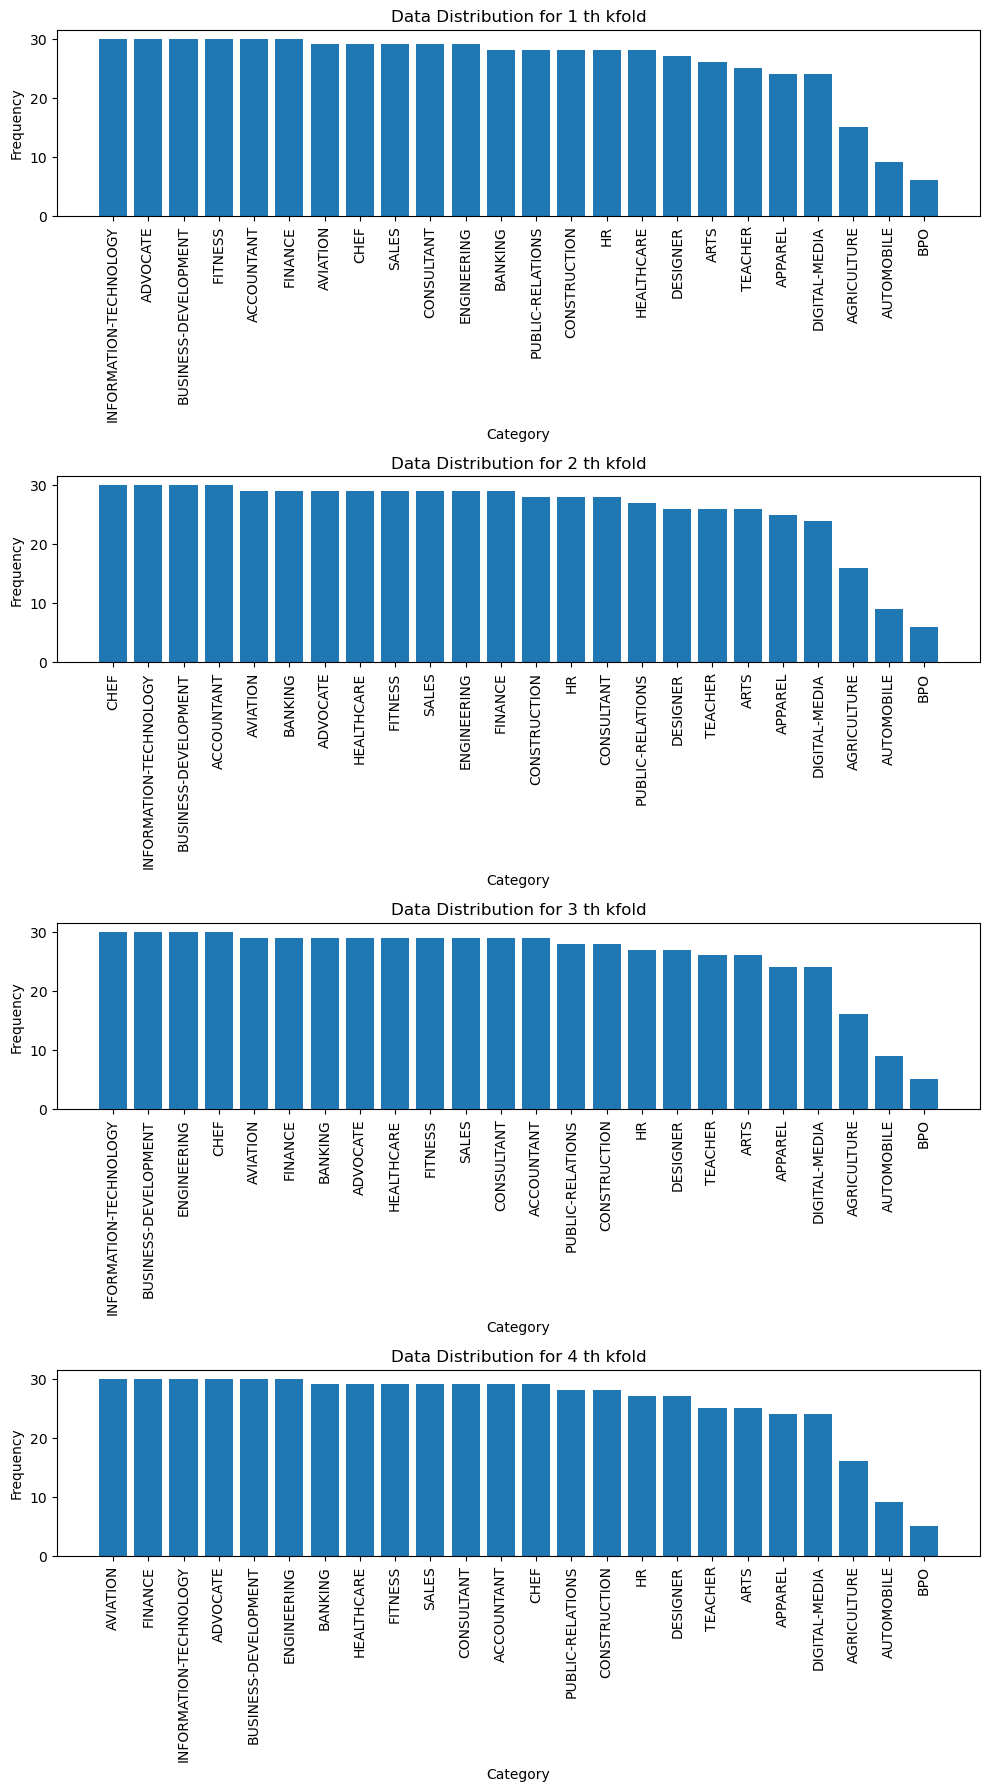

In [51]:
## lets see the data distribution for each split
temp_df= data_df[['labels', 'kfold']]
plt.figure(figsize= (10, 16))

for i in range(CONFIG.n_fold + 1):
    xlabels= temp_df[temp_df['kfold'] == i]['labels'].value_counts().index
    xlabels= [id2label[str(id_)] for id_ in xlabels]
    ylabels= temp_df[temp_df['kfold'] == i]['labels'].value_counts().values
    
    plt.subplot(CONFIG.n_fold + 1 ,1,i+1)
    plt.bar(xlabels, height= ylabels, align= 'center')
    
    plt.tight_layout()
    plt.title(f"Data Distribution for {i+1} th kfold")
    plt.xticks(rotation = 'vertical')
    plt.xlabel("Category")
    plt.ylabel("Frequency")

From the above distribution plots we can see that each splits has data from each categories. So, Our data is evenly distributed for training.

In [52]:
test_df= data_df[data_df['kfold']== 3].reset_index(drop= True)
train_df= data_df[data_df['kfold'] != 3].reset_index(drop= True)

print(f"Total data in train dataset: {len(train_df)}")
print(f"Total data in test dataset: {len(test_df)}")

train_df= train_df[['ID', 'Resume_str', 'Category', 'labels', 'kfold']]
test_df= test_df[['ID', 'Resume_str', 'Category', 'labels', 'kfold']]

train_df.to_csv("train_data.csv", index= False)
print("Train Data is saved to 'train_data.csv'")
test_df.to_csv("test_data.csv", index= False)
print("Test Data is saved to 'test_data.csv'")

Total data in train dataset: 1863
Total data in test dataset: 621
Train Data is saved to 'train_data.csv'
Test Data is saved to 'test_data.csv'


In [53]:
def set_seed(seed= 42):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic= True
    torch.backends.cudnn.benchmark= False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CONFIG.seed)


In [54]:
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
from transformers import AutoModel, AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding

In [55]:
# data= train_df[train_df["Resume_str", 'labels', 'kfold']]
# valid= data[data['kfold'] == 0]['']

In [56]:
tokenizer= AutoTokenizer.from_pretrained(CONFIG.model_name_or_path)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [57]:
train_df['Resume_str'].values[0]

'hr administrator/marketing associate hr administrator summary dedicated customer service manager with 15+ years of experience in hospitality and customer service management. respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service. highlights focused on customer satisfaction team management marketing savvy conflict resolution techniques training and development skilled multi-tasker client relations specialist accomplishments missouri dot supervisor training certification certified by ihg in customer loyalty and marketing by segment hilton worldwide general manager training certification accomplished trainer for cross server hospitality systems such as hilton onq , micros opera pms , fidelio opera reservation system (ors) , holidex completed courses and seminars in customer service, sales strategies, inventory control, loss prevention, safety, time management, leadership and performance assessment. experience hr ad

In [58]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, cfg= CONFIG):
        self.df= df
        self.max_len= cfg.token_max_length
        self.tokenizer= tokenizer
        self.full_text= df['Resume_str'].values
        self.labels= df['labels'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text= self.full_text[index]

        # tokenizer.encode_plus from huggingface.
        inputs= self.tokenizer.encode_plus(
            text,
            truncation= True,
            add_special_tokens= True,
            max_length= self.max_len,
            padding= False, 
        )
        
        input_ids= inputs['input_ids']
        if len(input_ids) > self.max_len -1 :
            input_ids= input_ids[:self.max_len -1]
        
        input_ids = input_ids + [self.tokenizer.sep_token_id]
        
        attention_mask= [1] * len(input_ids)
        labels= self.labels[index]
        
        return {
            'input_ids' : input_ids,
            'attention_mask' : attention_mask,
            'targets' : labels
        }

In [59]:
collate_fn= DataCollatorWithPadding(tokenizer, padding= True, max_length= CONFIG.token_max_length, return_tensors= 'pt')

In [60]:
def prepare_loader(df, fold, cfg= CONFIG):
    df_train= df[df.kfold != fold].reset_index(drop= True) # 2 fold out of 3 fold is used as training data, and 1 fold for validation.
    df_valid= df[df.kfold == fold].reset_index(drop= True)
    valid_labels = df_valid['labels'].values
    
    # converting dataFrame to dataset.
    train_dataset= CustomDataset(df_train, tokenizer, cfg)
    valid_dataset= CustomDataset(df_valid, tokenizer, cfg)
    
    train_loader= DataLoader(train_dataset, 
                             batch_size= cfg.train_batch_size, 
                             collate_fn= collate_fn, #merges a list of samples to form a mini-batch of Tensors
                             num_workers= cfg.num_workers, # how many subprocesses to use for data loading
                             shuffle= True, 
                             pin_memory= True,
                             drop_last= False, )
    
    valid_loader= DataLoader(valid_dataset, 
                            batch_size= cfg.valid_batch_size,
                            collate_fn= collate_fn, 
                            num_workers= cfg.num_workers,
                            shuffle= False,
                            pin_memory= True, #If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
                            drop_last= False,
                            )
    
    return train_loader, valid_loader #, df_train, df_valid, valid_labels

In [61]:
# training_args = TrainingArguments(
#     output_dir="./checkpoints",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     metric_for_best_model="F1",
#     num_train_epochs=1,
#     weight_decay=0.01,
#     include_inputs_for_metrics =True,
#     seed = 0,
#     save_steps=3500
# )


In [62]:
import torch.optim as optim
import torch.nn as nn
import gc

In [63]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
    
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded= attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings= torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask= input_mask_expanded.sum(1)
        sum_mask= torch.clamp(sum_mask, min= 1e-9)
        mean_embeddings= sum_embeddings/sum_mask
        return mean_embeddings

In [64]:
class ResumeClassifier(nn.Module):
    def __init__(self, model_name = CONFIG.model_name_or_path):
        super(ResumeClassifier, self).__init__()
        
        self.num_labels= CONFIG.num_labels
        self.config= AutoConfig.from_pretrained(model_name) #, max_position_embeddings= CONFIG['max_length']
        self.model= AutoModel.from_pretrained(model_name, config= self.config)
#         self.model.gradient_checkpointing_enable() #for gradient checkpointing.
        
        self.drop= nn.Dropout(0.0)
        self.pooler= MeanPooling()
        self.fc= nn.Linear(self.config.hidden_size, self.num_labels)#
        
        
    def forward(self, input_ids, attention_mask): # forward : Defines the computation performed at every call.
        out= self.model(input_ids= input_ids, 
                        attention_mask= attention_mask,
                        output_hidden_states= True,)#False
        out= self.pooler(out.last_hidden_state, attention_mask)
#         out= out[1] #.pooler_output #[1] 
        #out= self.drop(out)
        outputs= self.fc(out)
        
        return outputs
    

In [65]:
model= ResumeClassifier(CONFIG.model_name_or_path)
model

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ResumeClassifier(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
  

In [66]:
from sklearn.metrics import f1_score, accuracy_score
def get_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average= 'macro')
def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [67]:
y= [10, 15, 10]
x= [10, 10, 10]
x = y

In [68]:
def get_optimizer(parameters, cfg= CONFIG):
    return AdamW(params=parameters, lr= cfg.learning_rate, weight_decay= cfg.weight_decay, eps= cfg.eps, betas= cfg.betas)

In [69]:
def fetch_scheduler(optimizer, cfg= CONFIG):
    """
    Gets leanring rate schedular for given optimizer
    """
    if cfg.scheduler == "CosineAnnealingLR":
        scheduler= lr_scheduler.CosineAnnealingLR(optimizer, T_max= cfg.T_max, eta_min= cfg.min_lr)
    elif cfg.scheduler == "CosineAnnealingWarmRestarts":
        scheduler= lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= cfg.T_0, eta_min= cfg.min_lr)
    elif cfg.scheduler== "linear":
        scheduler= lr_scheduler.LinearLR(optimizer, start_factor= 0.01, end_factor= 1.0, total_iters= 100)
    elif cfg.scheduler == None:
        return None

    return scheduler

In [70]:
def train_one_epoch(model, optimizer, scheduler, dataloader, epoch, device):
    
    model.train()
    dataset_size= 0
    running_loss= 0.0
    
    steps= len(dataloader)
    bar= tqdm(enumerate(dataloader), total= len(dataloader))
    
    for step, data in bar:
        # sending data to cpu or gpu if cuda avaiable.
        ids= data["input_ids"].to(device, dtype= torch.long)
        masks= data["attention_mask"].to(device, dtype= torch.long)
        targets= data["targets"].to(device, dtype= torch.long)
        
        batch_size= ids.size(0)
        
        #computing model output
        outputs= model(ids, masks)
        
        #loss calcuation
        loss= nn.CrossEntropyLoss()(outputs, targets)
        if CONFIG.gradient_accumulation_steps > 1:
            loss= loss / CONFIG.gradient_accumulation_steps
        
        loss.backward()
        
        ## Gradient Accumulation
        if (step + 1) % CONFIG.gradient_accumulation_steps == 0 or step == steps - 1:
            
            optimizer.step() #Performs a single optimization step (parameter update)
            
            # clear out the gradients of all Variables 
            # in this optimizer (i.e. W, b)
            optimizer.zero_grad()
            
            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss= running_loss / dataset_size
        
        bar.set_postfix(Epoch= epoch, 
                        Train_Loss = epoch_loss,
                        LR= optimizer.param_groups[0]['lr'],
                       )
    return epoch_loss

In [71]:
@torch.no_grad()

def valid_one_epoch(model, dataloader, epoch, device):
    model.eval()
    
    dataset_size= 0
    running_loss= 0.0
    
    preds= []
    labels= []

    bar= tqdm(enumerate(dataloader), total= len(dataloader))
    
    for step, data in bar:
        ids= data["input_ids"].to(device, dtype= torch.long)
        masks= data["attention_mask"].to(device, dtype= torch.long)
        targets= data["targets"].to(device, dtype= torch.long)
        
        batch_size= ids.size(0)
        
        outputs= model(ids, masks)
        
        loss= nn.CrossEntropyLoss()(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss= running_loss / dataset_size
        
        preds.append(outputs.argmax(axis=1).to('cpu').numpy())
        labels.append(targets.to('cpu').numpy())
        bar.set_postfix(Epoch= epoch, 
                        Valid_Loss = epoch_loss,
                       )
    predictions= np.concatenate(preds)
    true_labels= np.concatenate(labels)
    f1score= get_score(true_labels, predictions)
    accuracy= get_accuracy(true_labels, predictions)
    
    return epoch_loss, f1score, accuracy

In [72]:
import pickle

In [73]:
def training_loop(model, train_loader, valid_loader, optimizer, scheduler, fold, num_epochs, cfg= CONFIG, patience= 3):

    if torch.cuda.is_available():
        print("Training with GPU\n")
    else:
        Print("Training with CPU \n")
    
    start= time.time()
    best_score= - np.inf
    trigger_times= 0 # for early stoping
    
    history= defaultdict(list)

    for epoch in range(1, num_epochs + 1):

        train_epoch_loss= train_one_epoch(model, optimizer, scheduler, dataloader= train_loader, epoch= epoch, device= cfg.device)
        val_epoch_loss, f1score, accuracy= valid_one_epoch(model, valid_loader, epoch= epoch, device= cfg.device)
        
        history['train_loss'].append(train_epoch_loss)
        history['valid_loss'].append(val_epoch_loss)
        history['F1_score'].append(f1score)
        history['Accuracy'].append(accuracy)
        
        
        # Log the metrics for W&B
        if cfg.wandb:
            wandb.log({"epoch": epoch ,"Train Loss": train_epoch_loss, "Valid Loss": val_epoch_loss})


        if f1score >= best_score:
            
            trigger_times= 0 #for early stop
            print(f"Validation Score Improved ({best_score :.4f} ---> {f1score :.4f})")
            print(f"Validation Accuracy: {accuracy :.4f}")
            
            best_score= f1score
            
            
            # copy and save model
            best_model_wts= copy.deepcopy(model.state_dict())
            PATH= f"Resume_Classification_fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)

            print(f"Model Saved to {PATH}")
            
            if cfg.wandb:
                run.summary['Best Score'] = best_score # for w&b summary
                run.summary['Accuracy'] = accuracy
        
        else:
            trigger_times += 1
            
            if trigger_times >= patience:
                print("Early stoping \n")
                break

        
    end= time.time()
    time_elapsed= end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    print(f"Best F1 Score: {best_score:.4f}")
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    if cfg.wandb:
        run.join()

    return model, history, best_score, accuracy


In [74]:
import copy
def main():
    scores = []
    accuracy= []
    for fold in range(0, CONFIG.n_fold):
        print("="*10 + f" Training fold {fold} " + "="*10)
        
        if CONFIG.wandb:
            run = wandb.init(project='Resueme Classification', 
                             job_type='Train',
                             group=CONFIG.group,
                             tags=[CONFIG.model_name_or_path, f'{HASH_NAME}'],
                             name=f'Resume_class-{HASH_NAME}-fold-{fold}',
                             anonymous='must')

    #     artifact = wandb.Artifact('model', type='model')

        # Create Dataloaders
        train_loader, valid_loader = prepare_loader(train_df, fold= fold, cfg= CONFIG)

        # Model
        model= ResumeClassifier(model_name= CONFIG.model_name_or_path)
        model.to(device= CONFIG.device)

        # Optimizer
        optimizer= get_optimizer(model.parameters(), cfg= CONFIG)
        
        scheduler= fetch_scheduler(optimizer, cfg= CONFIG)
        
        criterion= nn.CrossEntropyLoss()
        model, history, fold_best_score, fold_accuracy= training_loop(model, train_loader, valid_loader,
                                                                      optimizer, 
                                                                      scheduler,
                                                                      num_epochs= CONFIG.num_epochs, 
                                                                      fold= fold,
                                                                      patience= 3,
                                                                      cfg= CONFIG
                                                                      )
        
        
        scores.append(fold_best_score)
        accuracy.append(fold_accuracy)
#         history.to_csv(f"history_fold{fold}.csv", index= False)
        with open(f'history_fold_{fold}.pickle', 'wb') as f:
            pickle.dump(history, f)
        
        if CONFIG.wandb:
            run.finish() # for w&b
        
        print("="*10 + f"Fold {fold} best score" + '=' * 10)
        print(f"F1 Score: {fold_best_score :.4f}")
        print(f"Accuracy: {fold_accuracy: .4f}")
        print("="* 30)

        del model, history, train_loader, valid_loader
        gc.collect()
    

    print("="*10 + "Ovaerall Performance" + '=' * 10)
    print(f"F1 Score: {np.mean(scores):.4f}")
    print(f"Accuracy: {np.mean(accuracy): .4f}")
    print("="* 30)
    
    return np.mean(scores)

In [75]:
if __name__ == "__main__":
    if CONFIG.train:
        main()
    

========== Training fold 0 ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training with GPU



  0%|          | 0/621 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 0/311 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding

Validation Score Improved (-inf ---> 0.0032)
Validation Accuracy: 0.0403
Model Saved to Resume_Classification_fold-0.bin


  0%|          | 0/621 [00:00<?, ?it/s]You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  1%|          | 4/621 [00:06<15:41,  1.53s/it, Epoch=2, LR=1.71e-5, Train_Loss=3.21]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 if __name__ == "__main__":                                                                   │
│   2 │   if CONFIG.train:                                                                         │
│ ❱ 3 │   │   main()                                                                               │
│   4                                                                                              │
│   5                                                                                              │
│                                                                                                  │
│ in main:31                                                                                       │
│                                                                                                  │
│   28 │   │   scheduler= fetch_scheduler(optimizer, cfg= CONFIG)                                  │
│   29 │   │                                                                                       │
│   30 │   │   criterion= nn.CrossEntropyLoss()                                                    │
│ ❱ 31 │   │   model, history, fold_best_score, fold_accuracy= training_loop(model, train_loade    │
│   32 │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │     optimizer,            │
│   33 │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │     scheduler,            │
│   34 │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │     num_epochs= CONFIG    │
│                                                                                                  │
│ in training_loop:16                                                                              │
│                                                                                                  │
│   13 │                                                                                           │
│   14 │   for epoch in range(1, num_epochs + 1):                                                  │
│   15 │   │                                                                                       │
│ ❱ 16 │   │   train_epoch_loss= train_one_epoch(model, optimizer, scheduler, dataloader= train    │
│   17 │   │   val_epoch_loss, f1score, accuracy= valid_one_epoch(model, valid_loader, epoch= e    │
│   18 │   │                                                                                       │
│   19 │   │   history['train_loss'].append(train_epoch_loss)                                      │
│                                                                                                  │
│ in train_one_epoch:31                                                                            │
│                                                                                                  │
│   28 │   │   ## Gradient Accumulation                                                            │
│   29 │   │   if (step + 1) % CONFIG.gradient_accumulation_steps == 0 or step == steps - 1:       │
│   30 │   │   │                                                                                   │
│ ❱ 31 │   │   │   optimizer.step() #Performs a single optimization step (parameter update)        │
│   32 │   │   │                                                                                   │
│   33 │   │   │   # clear out the gradients of all Variables                                      │
│   34 │   │   │   # in this optimizer (i.e. W, b)                                                 │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/optim/lr_sche

In [ ]:
# history

In [ ]:
# from tqdm import tqdm
# train_dataloader, valid_dataloader= prepare_loader(data_df, fold= 0)
# model= CustomModel(CONFIG.model_name_or_path)
# model.to(CONFIG.device)
# model.train()
# optimizer = optim.SGD(model.parameters(), lr=0.0001)

# prog_bar= tqdm(enumerate(train_dataloader), total= len(train_dataloader))
# device= CONFIG.device

# for setp, data in prog_bar:
#     optimizer.zero_grad()
#     ids= data['input_ids'].to(device)#, dtype= torch.long
#     masks= data["attention_mask"].to(device)#, dtype= torch.long
#     targets= data["targets"].to(device)#, dtype= torch.long
    
#     outputs= model(input_ids = ids, 
#                    attention_mask= masks)
    
#     loss = criterion(outputs, targets)

#     loss.backward()
#     optimizer.step()

# torch.save(model.state_dict(), f'model.pt')

In [ ]:
# inputs= tokenizer.encode_plus(test_df['Resume_str'][0],
#                               truncation= True, 
#                               max_length= CONFIG.token_max_length, 
#                               return_token_type_ids= False,
#                               return_tensors= 'pt'
#                              ).to(CONFIG.device)
# inputs, test_df['labels'][0]

In [ ]:
# # model.eval()
# model(**inputs).argmax(axis=1)[0]

## Testing

In [ ]:
def testing_loop(model, dataloader, device):
    model.eval()
    
    preds= []
    labels= []

    bar= tqdm(enumerate(dataloader), total= len(dataloader))
    
    for step, data in bar:
        ids= data["input_ids"].to(device, dtype= torch.long)
        masks= data["attention_mask"].to(device, dtype= torch.long)
        targets= data["targets"].to(device, dtype= torch.long)
        
        batch_size= ids.size(0)
        
        with torch.no_grad():
            outputs= model(ids, masks)

        preds.append(outputs.argmax(axis=1).to('cpu').numpy())
        labels.append(targets.to('cpu').numpy())
        bar.set_postfix(F1_score= get_score(np.concatenate(labels), np.concatenate(preds)))

    predictions= np.concatenate(preds)
    true_labels= np.concatenate(labels)
    f1score= get_score(true_labels, predictions)
    accuracy= get_accuracy(true_labels, predictions)

    print(f"====== xxxx ======")
    print(f"Overall F1 Score: {f1score}")
    print(f"Overall  Accuracy: {accuracy}")
    print(f"====== xxxx ======")
    
    return predictions, f1score, accuracy

In [ ]:
!pip install -q dotmap

from dotmap import DotMap

In [ ]:
model_checkpoints= [
    "/kaggle/input/resume-classification-task-model-weights/Resume_Classification-0.bin",
    "/kaggle/input/resume-classification-task-model-weights/Resume_Classification-1.bin",
    "/kaggle/input/resume-classification-task-model-weights/Resume_Classification-2.bin"
]

configuration_path= "/kaggle/working/Configuration.json" #"/kaggle/input/resume-classification-task-model-weights/Configuration.json"

# with open(configuration_path) as f:
#     CONFIG= DotMap(json.load(f))

# id2label= CONFIG.id2label

In [ ]:
test_dataset= CustomDataset(test_df, tokenizer, CONFIG)
test_loader= DataLoader(test_dataset, 
                        batch_size= CONFIG.test_batch_size,
                        collate_fn= collate_fn, 
                        num_workers= CONFIG.num_workers,
                        shuffle= False,
                        pin_memory= True, #If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
                        drop_last= False,
                        )

In [ ]:
CONFIG.test = True
model_checkpoint= "/kaggle/working/Resume_Classification_fold-0.bin" #model_checkpoints[0]

if CONFIG.test:
    with open(configuration_path) as f:
        CONFIG= DotMap(json.load(f))
    id2label= dict(CONFIG.id2label)
    test_dataset= CustomDataset(test_df, tokenizer, CONFIG)
    test_loader= DataLoader(test_dataset, 
                            batch_size= CONFIG.test_batch_size,
                            collate_fn= collate_fn, 
                            num_workers= CONFIG.num_workers,
                            shuffle= False,
                            pin_memory= True, #If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
                            drop_last= False,
                            )
    
    device= torch.device("cuda" if torch.cuda.is_available else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(CONFIG.model_name_or_path)
    model= ResumeClassifier(CONFIG.model_name_or_path)
    model.load_state_dict(torch.load(model_checkpoint, map_location=  device))
    model.to(device)
    
    predictions, test_f1_score, test_accuracy= testing_loop(model, test_loader, device)
    predictions= [id2label[str(p)] for p in predictions]
    test_df['Model_predictions']= predictions
    test_df= test_df[["ID", "Resume_str", "Category", "Model_predictions" ]]
    test_df.to_csv("Results.csv", index= False)

In [ ]:
# temp= test_df[["ID"]]
# temp# dict(id2label)

##  End-to-End Prediction

In [ ]:
!pip install -q dotmap

from dotmap import DotMap

In [ ]:
model_checkpoints= [
    "/kaggle/input/resume-classification-task-model-weights/Resume_Classification-0.bin",
    "/kaggle/input/resume-classification-task-model-weights/Resume_Classification-1.bin",
    "/kaggle/input/resume-classification-task-model-weights/Resume_Classification-2.bin"
]
configuration_path= "/kaggle/input/resume-classification-task-model-weights/Configuration.json"

with open(configuration_path) as f:
    CONFIG= DotMap(json.load(f))

id2label= CONFIG.id2label

In [ ]:
def run_prediction(text, model, tokenizer, device ,cfg= CONFIG):
    inputs= tokenizer.encode_plus(text, padding=True, truncation=True, return_tensors="pt")
    outputs= model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
    outputs= outputs.detach().cpu().numpy().argmax(axis= -1)[0]
    
    return id2label[str(outputs)]

def inference_fn(text, model_name= None, model_checkpoint= None, cfg= CONFIG):
    
    device= torch.device("cuda" if torch.cuda.is_available else 'cpu')
    # loading model and weights
    if model_name is not None:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model= ResumeClassifier(model_name= model_name)
    else:
        tokenizer = AutoTokenizer.from_pretrained(cfg.model_name_or_path)
        model= ResumeClassifier(cfg.model_name_or_path)
        
    if model_checkpoint != None:
        model.load_state_dict(torch.load(model_checkpoint, map_location=  device))
    else:
        model.load_state_dict(torch.load(cfg.model_checkpoint, map_location=  device))
    
    model.to(device)
    ## processing inputs
    if type(text) == str:
        output= run_prediction(text, model, tokenizer, device, cfg)
        print(f"Predicted class for the given resume is {output}")
    else:
        output= None
        print("Please give input in proper format")
    
    return output

In [ ]:
idx= 50
text= test_df['Resume_str'][idx]
model_checkpoint= model_checkpoints[0]

pred_class= inference_fn(text, CONFIG.model_name_or_path, model_checkpoint, cfg= CONFIG)
true_class= test_df["Category"][idx]

print()